In  a docker terminal run
jupyter notebook --ip=0.0.0.0 --port=8888 --no-browser --allow-root

then open jupyter in the printed link (such as http://127.0.0.1:8888/tree?token=4d9d578397aede50fc5bd2d92794b562a6bbcbc73b2dfe51)

CODE HERE, REFRESH AND EXECUTE IN THE BROWSER

In [1]:
import os
import sys
import django

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


In [2]:
sys.path.append('/app')

os.environ['DJANGO_SETTINGS_MODULE'] = 'app.settings'
os.environ['PYTHONPATH'] = '/app'

django.setup()

ModuleNotFoundError: No module named 'app'

In [3]:
from toolbox import models
from django.forms.models import model_to_dict
import numpy as np
import json
from django.contrib.gis.geos import GEOSGeometry, Polygon, MultiPolygon

In [4]:
import pandas as pd

In [15]:
sinks = models.Sink.objects.filter(pk__in=( 4, 58362))

In [16]:
from django.db.models import Prefetch
import pandas as pd

soil_qs = models.SinkSoilProperties.objects.filter(
    sink__in=sinks
).select_related(
    'sink',
    'soil_properties__groundwater_distance',
    'soil_properties__agricultural_landuse',
    'soil_properties__fieldcapacity',
    'soil_properties__hydromorphy',
    'soil_properties__soil_texture',
    'soil_properties__wet_grassland',
).values(
    'sink_id',
    'percent_of_total_area',
    'soil_properties__groundwater_distance__rating_index',
    'soil_properties__nitrate_contamination',
    'soil_properties__waterlog',
    'soil_properties__agricultural_landuse__name',
    'soil_properties__fieldcapacity__rating_index',
    'soil_properties__hydromorphy__rating_index',
    'soil_properties__soil_texture__rating_index',
    'soil_properties__wet_grassland__rating_index',
    'soil_properties__hydraulic_conductivity_1m_rating',
    'soil_properties__hydraulic_conductivity_2m_rating',
)



In [18]:
df= pd.DataFrame.from_records(soil_qs)

In [29]:
w_usability = .20
w_soil = .80

w_fg_fc = .33
w_fg_hc1 = .33
w_fg_hc2 = .33

w_ag_fc = .33
w_ag_hydro = .33
w_ag_soil = .33

w_gr_fc = .25
w_gr_hydro = .25
w_gr_soil = .25
w_gr_wet = .25

In [30]:
df['bool_general'] = (~df['soil_properties__nitrate_contamination']) & (~df['soil_properties__waterlog'])
df['index_1'] = df['bool_general'] * df['soil_properties__groundwater_distance__rating_index']


In [31]:
df

,sink_id,percent_of_total_area,soil_properties__groundwater_distance__rating_index,soil_properties__nitrate_contamination,soil_properties__waterlog,soil_properties__agricultural_landuse__name,soil_properties__fieldcapacity__rating_index,soil_properties__hydromorphy__rating_index,soil_properties__soil_texture__rating_index,soil_properties__wet_grassland__rating_index,soil_properties__hydraulic_conductivity_1m_rating,soil_properties__hydraulic_conductivity_2m_rating,bool_general,index_1,index_2,index_be,weighted_index
0,58362,0.830050,0.14,False,False,fields,0.97,1.0,1.00,0.0,1.0,1.0,True,0.14,98.01,7840.828,6508.281840
1,4,1.000000,1.00,False,False,no_agricultural_use,0.87,0.0,0.00,0.0,1.0,1.0,True,1.00,94.71,7577.000,7577.000000
2,58362,0.143033,0.14,False,False,fields,1.00,1.0,1.00,0.0,1.0,1.0,True,0.14,99.00,7920.028,1132.826546
3,58362,0.026917,0.14,False,False,fields,0.97,1.0,0.88,0.0,1.0,1.0,True,0.14,94.05,7524.028,202.520684


In [32]:
def compute_index_2(row):
    landuse = row['soil_properties__agricultural_landuse__name']
    if landuse == 'grassland':
        return (
            w_gr_fc * row['soil_properties__fieldcapacity__rating_index'] +
            w_gr_hydro * row['soil_properties__hydromorphy__rating_index'] +
            w_gr_soil * row['soil_properties__soil_texture__rating_index'] +
            w_gr_wet * row['soil_properties__wet_grassland__rating_index']
        )
    elif landuse == 'no_agricultural_use':
        return (
            w_fg_fc * row['soil_properties__fieldcapacity__rating_index'] +
            w_fg_hc1 * row['soil_properties__hydraulic_conductivity_1m_rating'] +
            w_fg_hc2 * row['soil_properties__hydraulic_conductivity_2m_rating']
        )
    else:
        return (
            w_ag_fc * row['soil_properties__fieldcapacity__rating_index'] +
            w_ag_hydro * row['soil_properties__hydromorphy__rating_index'] +
            w_ag_soil * row['soil_properties__soil_texture__rating_index']
        )

df['index_2'] = df.apply(compute_index_2, axis=1)
df['index_be'] = w_usability * df['index_1'] + w_soil * df['index_2']
df['weighted_index'] = df['index_be'] * df['percent_of_total_area']


In [33]:
df

,sink_id,percent_of_total_area,soil_properties__groundwater_distance__rating_index,soil_properties__nitrate_contamination,soil_properties__waterlog,soil_properties__agricultural_landuse__name,soil_properties__fieldcapacity__rating_index,soil_properties__hydromorphy__rating_index,soil_properties__soil_texture__rating_index,soil_properties__wet_grassland__rating_index,soil_properties__hydraulic_conductivity_1m_rating,soil_properties__hydraulic_conductivity_2m_rating,bool_general,index_1,index_2,index_be,weighted_index
0,58362,0.830050,0.14,False,False,fields,0.97,1.0,1.00,0.0,1.0,1.0,True,0.14,0.9801,0.81208,0.674067
1,4,1.000000,1.00,False,False,no_agricultural_use,0.87,0.0,0.00,0.0,1.0,1.0,True,1.00,0.9471,0.95768,0.957680
2,58362,0.143033,0.14,False,False,fields,1.00,1.0,1.00,0.0,1.0,1.0,True,0.14,0.9900,0.82000,0.117287
3,58362,0.026917,0.14,False,False,fields,0.97,1.0,0.88,0.0,1.0,1.0,True,0.14,0.9405,0.78040,0.021006


In [35]:
sink_indices = df.groupby('sink_id')['weighted_index'].sum().round(3).to_dict()
sink_indices

{4: 0.958, 58362: 0.812}

In [4]:
sinks = models.EnlargedSink.objects.all()

In [5]:
for s in sinks:
    if '%' in s.land_use_1:
        
        land_use_1 = s.land_use_1.split(' ')[0]
        land_use_1_percentage = (s.land_use_1.split(' ')[1]).split('%')[0]
        land_use_1_percentage = land_use_1_percentage.replace(',', '.')
        land_use_1_percentage = float(land_use_1_percentage)
        s.land_use_1 = land_use_1
        s.land_use_1_percentage = land_use_1_percentage
        if s.land_use_2 and '%' in s.land_use_2:
        
            land_use_2 = s.land_use_2.split(' ')[0]
            land_use_2_percentage = (s.land_use_2.split(' ')[1]).split('%')[0]
            land_use_2_percentage = land_use_2_percentage.replace(',', '.')
            land_use_2_percentage = float(land_use_2_percentage)
            
            s.land_use_2 = land_use_2
            s.land_use_2_percentage = land_use_2_percentage
            if s.land_use_3 and '%' in s.land_use_3:
            
                land_use_3 = s.land_use_3.split(' ')[0]
                land_use_3_percentage = (s.land_use_3.split(' ')[1]).split('%')[0]
                land_use_3_percentage = land_use_3_percentage.replace(',', '.')
                land_use_3_percentage = float(land_use_3_percentage)
                
                s.land_use_3 = land_use_3
                s.land_use_3_percentage = land_use_3_percentage
                if s.land_use_4 and '%' in s.land_use_4:
                
                    land_use_4 = s.land_use_4.split(' ')[0]
                    land_use_4_percentage = (s.land_use_4.split(' ')[1]).split('%')[0]
                    land_use_4_percentage = land_use_4_percentage.replace(',', '.')
                    land_use_4_percentage = float(land_use_4_percentage)
                    
                    s.land_use_4 = land_use_4
                    s.land_use_4_percentage = land_use_4_percentage
        s.save()
        

In [10]:
with open('landuse_sink_v2.geojson') as f:
         gjson =  json.load(f)


In [11]:
for feat in gjson['features']:
    ls = models.LanduseSink()
    geom = GEOSGeometry(str(feat['geometry']))
    geom.srid = 25833
    ls.geom = geom
    ls.sink = models.Sink.objects.get(pk=feat['properties']['id'])
    ls.landuse = models.Landuse.objects.get(pk=feat['properties']['landuse_id'])
    ls.total_area = feat['properties']['area']
    ls.save()

In [37]:
with open('landuse_enlarged_sink.geojson') as f:
         gjson =  json.load(f)


In [38]:
for feat in gjson['features']:
    ls = models.LanduseEnlargedSink()
    geom = GEOSGeometry(str(feat['geometry']))
    geom.srid = 25833
    ls.geom = geom
    ls.sink = models.Sink.objects.get(pk=feat['properties']['id'])
    ls.landuse = models.Landuse.objects.get(pk=feat['properties']['landuse_id'])
    ls.total_area = feat['properties']['area']
    ls.save()

In [4]:
sinks = models.Sink.objects.all()
enlarged_sinks = models.EnlargedSink.objects.all()

In [5]:
sinks[0].id


44601

In [6]:
def get_landuse(lu):
    if lu is not None:
        landuse = models.Landuse.objects.get(sink_landuse_name=lu)
        return landuse
    else: 
        return None
        


In [7]:
get_landuse(None)
s = sinks[0]
    


In [12]:
sinks[1716:1717][0]

<Sink: Sink object (32515)>

In [14]:
for s in sinks[1716:]:
    try:
        new = models.SinkX(
            geom = s.geom,
            geom25833 = s.geom25833,
            geom_simplified = s.geom_simplified,
            centroid = s.centroid,
            depth = s.depth,
            area = s.area,
            volume = s.volume, 
            shape_length = s.shape_length,
            index_1 = s.index_1,
            index_2 = s.index_2,
            index_3 = s.index_3,
            land_use_1 = s.land_use_1,
            landuse_1 = get_landuse(s.land_use_1),
            land_use_2 = s.land_use_2,
            landuse_2 = get_landuse(s.land_use_2),
            land_use_3 = s.land_use_3,
            landuse_3 = get_landuse(s.land_use_3),
            land_use_1_percentage = s.land_use_1_percentage,
            land_use_2_percentage = s.land_use_2_percentage,
            land_use_3_percentage = s.land_use_3_percentage,
            index_soil = s.index_soil,
            index_hydrology = s.index_hydrology,
            feasibility_sinks_index = s.feasibility_sinks_index,
            old_id = s.id,
            
            )
        new.save()
    except:
        print('failed:', s.id)

In [15]:
for s in enlarged_sinks:
    try:
        new = models.EnlargedSinkX(
            geom = s.geom,
            geom25833 = s.geom25833,
            geom_simplified = s.geom_simplified,
            centroid = s.centroid,
            depth = s.depth,
            area = s.area,
            volume = s.volume, 
            shape_length = s.shape_length,
            index_1 = s.index_1,
            index_2 = s.index_2,
            index_3 = s.index_3,
            land_use_1 = s.land_use_1,
            landuse_1 = get_landuse(s.land_use_1),
            land_use_2 = s.land_use_2,
            landuse_2 = get_landuse(s.land_use_2),
            land_use_3 = s.land_use_3,
            landuse_3 = get_landuse(s.land_use_3),
            land_use_4 = s.land_use_4,
            landuse_4 = get_landuse(s.land_use_4),
            land_use_1_percentage = s.land_use_1_percentage,
            land_use_2_percentage = s.land_use_2_percentage,
            land_use_3_percentage = s.land_use_3_percentage,
            land_use_4_percentage = s.land_use_4_percentage,
            index_soil = s.index_soil,
            index_hydrology = s.index_hydrology,
            feasibility_sinks_index = s.feasibilty_enlarged_sinks_index,
            old_id = s.id,
            nat_length = s.nat_length,
            por_length = s.por_length,
            con_length = s.con_length,
            constructed_sink = s.constructed_sink,
            volume_construction_barrier = s.volume_construction_barrier,
            volume_gained =  s.volume_gained,
            construction_efficiciency = s.construction_efficiciency,
            shape_area = s.shape_area,        
            )
        new.save()
    except:
        print('failed:', s.id)

In [44]:
vals = models.InletPointsSinks.objects.all()
data = []
for val in vals:
    data.append((val.mean_surplus_volume/val.vol_sink, val.index_2))
data





[(152.08219178082192, 1.0),
 (2.155623513421679, 1.0),
 (35.384860557768924, 1.0),
 (389.54385964912285, 1.0),
 (1.1343039591315454, 1.0),
 (3.8072702331961588, 1.0),
 (1.6700387349103079, 1.0),
 (179.7894736842105, 1.0),
 (188.16949152542372, 1.0),
 (11.81063829787234, 1.0),
 (173.46875, 1.0),
 (59.60805369127517, 1.0),
 (117.79310344827586, 1.0),
 (162.0729927007299, 1.0),
 (202.77625570776254, 1.0),
 (142.33333333333331, 1.0),
 (2.1390106449592983, 1.0),
 (98.03090507726269, 1.0),
 (227.73333333333332, 1.0),
 (211.46666666666664, 1.0),
 (333.89473684210526, 1.0),
 (75.39558573853989, 1.0),
 (61.33701657458563, 1.0),
 (117.79310344827586, 1.0),
 (53.18323353293413, 1.0),
 (304.16438356164383, 1.0),
 (121.00272479564032, 1.0),
 (179.06451612903226, 1.0),
 (243.99999999999997, 1.0),
 (57.523316062176164, 1.0),
 (232.5026178010471, 1.0),
 (147.53488372093022, 1.0),
 (143.2516129032258, 1.0),
 (190.59227467811158, 1.0),
 (28.231404958677683, 1.0),
 (0.4195172641821359, 0.419518),
 (6.669

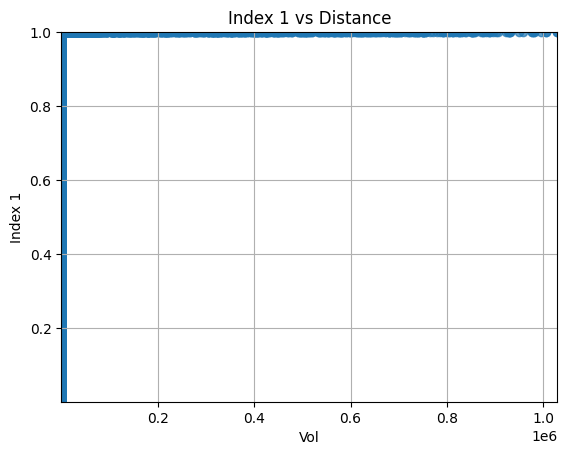

In [47]:
import matplotlib.pyplot as plt

# Separate the values
distances = [d[0] for d in data]
indices = [d[1] for d in data]

# Scatter plot
plt.scatter(distances, indices, alpha=0.7)
plt.xlabel('Vol')
plt.ylabel('Index 1')
plt.title('Index 1 vs Distance')
plt.grid(True)
plt.xlim(min(distances), max(distances))  # or plt.xlim(0, 200)
plt.ylim(min(indices), max(indices)) 
plt.show()

In [21]:
indices_1 = models.InletPointsSinks.objects.values('index_1').distinct()
for item in indices_1:
    indices_1 = models.InletPointsSinks.objects.filter(index_1 = item['index_1'])

<QuerySet [{'index_1': 0.4}, {'index_1': 0.2}, {'index_1': 0.9}, {'index_1': 0.6}, {'index_1': 1.0}, {'index_1': 0.1}, {'index_1': 0.7}, {'index_1': 0.5}, {'index_1': 0.3}, {'index_1': 0.05}, {'index_1': 0.8}]>

In [23]:
from django.db.models import Min
min_distances = models.InletPointsSinks.objects.values('index_1').annotate(min_distance=Min('distance'))
min_distances

<QuerySet [{'index_1': 0.4, 'min_distance': 600.08}, {'index_1': 0.2, 'min_distance': 800.02}, {'index_1': 0.9, 'min_distance': 100.01}, {'index_1': 0.6, 'min_distance': 400.04}, {'index_1': 1.0, 'min_distance': 0.0}, {'index_1': 0.1, 'min_distance': 900.06}, {'index_1': 0.7, 'min_distance': 300.03}, {'index_1': 0.5, 'min_distance': 500.02}, {'index_1': 0.3, 'min_distance': 700.03}, {'index_1': 0.05, 'min_distance': 1000.03}, {'index_1': 0.8, 'min_distance': 200.02}]>

In [26]:
distances = [d['min_distance'] for d in min_distances]
indices = [d['index_1'] for d in min_distances]

Linear equation: index_1 = -0.0010 * distance + 0.9932


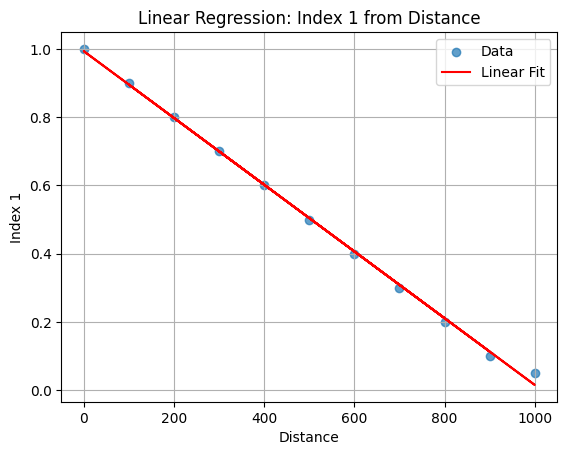

In [27]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Convert to 2D array for sklearn
X = np.array(distances).reshape(-1, 1)
y = np.array(indices)

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Get coefficients
slope = model.coef_[0]
intercept = model.intercept_

print(f"Linear equation: index_1 = {slope:.4f} * distance + {intercept:.4f}")

# Plot regression line
y_pred = model.predict(X)

plt.scatter(distances, indices, label='Data', alpha=0.7)
plt.plot(distances, y_pred, color='red', label='Linear Fit')
plt.xlabel('Distance')
plt.ylabel('Index 1')
plt.title('Linear Regression: Index 1 from Distance')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
project= {
    "id":None,
    "name":"",
    "updated":None,
    "description":"",
    "userField":56,
    "toolboxType":1,
    "infiltration":{
        "id":None,
        "sink_area_min":None,
        "sink_area_max":None,
        "sink_volume_min":None, 
        "sink_volume_max":None,
        "sink_depth_min":None,
        "sink_depth_max":None,
        "sink_index_soil_min":None,
        "sink_index_soil_max":None,
        "sink_land_use":["farmland","forest_conifers","forest_conifers_and_deciduous_trees","grassland","woody_area"],
        "selected_sinks":[125, 139, 76288,75305,75114,78200,78662,76222,75372,76163,76790,76266],
        "enlarged_sink_area_min":None,
        "enlarged_sink_area_max":None,
        "enlarged_sink_volume_min":None,
        "enlarged_sink_volume_max":None,
        "enlarged_sink_depth_min":None,
        "enlarged_sink_depth_max":None,
        "enlarged_sink_volume_construction_barrier_min":None,
        "enlarged_sink_volume_construction_barrier_max":None,
        "enlarged_sink_volume_gained_min":None,
        "enlarged_sink_volume_gained_max":None,
        "enlarged_sink_index_soil_min":None,
        "enlarged_sink_index_soil_max":None,
        "enlarged_sink_land_use":["farmland","forest_conifers","forest_conifers_and_deciduous_trees","grassland","woody_area"],
        "selected_enlarged_sinks":[],
        "stream_min_surplus_volume_min":None,
        "stream_min_surplus_volume_max":None,
        "stream_mean_surplus_volume_min":None,
        "stream_mean_surplus_volume_max":None,
        "stream_max_surplus_volume_min":None,
        "stream_max_surplus_volume_max":None,
        "stream_plus_days_min":None,
        "stream_plus_days_max":None,
        "stream_distance_to_userfield":0,
        "lake_min_surplus_volume_min":None,
        "lake_min_surplus_volume_max":None,
        "lake_mean_surplus_volume_min":None,
        "lake_mean_surplus_volume_max":None,
        "lake_max_surplus_volume_min":None,
        "lake_max_surplus_volume_max":None,
        "lake_plus_days_min":None,
        "lake_plus_days_max":None,
        "lake_distance_to_userfield":0,
        "weighting_overall_usability":20,
        "weighting_soil_index":80,
        "weighting_forest_field_capacity":33,
        "weighting_forest_hydraulic_conductivity_1m":33,
        "weighting_forest_hydraulic_conductivity_2m":33,
        "weighting_agriculture_field_capacity":33,
        "weighting_agriculture_hydromorphy":33,
        "weighting_agriculture_soil_type":33,
        "weighting_grassland_field_capacity":25,
        "weighting_grassland_hydromorphy":25,
        "weighting_grassland_soil_type":25,
        "weighting_grassland_soil_water_ratio":25
        }}

In [ ]:
sink_ids = toolbox_project['infiltration'].get('selected_sink')
sinks = models.Sink.objects.filter(id__in=sink_ids)

In [25]:
s_dicts = []
for s in sinks:
        #
        s_dicts.append(s)

In [27]:
one = sinks[4]

In [36]:
ssps = models.SinkSoilProperties.objects.filter(sink__in=sinks)

In [4]:
from django.shortcuts import render
from toolbox import models


from django.contrib.auth.decorators import login_required
from django.contrib.gis.geos import GEOSGeometry, LineString
from django.contrib.gis.measure import D
from django.contrib.gis.db.models import PointField
from django.contrib.gis.db.models.functions import Distance
from django.http import HttpResponse, HttpResponseRedirect, HttpRequest, HttpResponseBadRequest, JsonResponse
from django.views.decorators.csrf import csrf_protect
from django.forms.models import model_to_dict

from django.template.loader import render_to_string
from django.db import connection
from django.db.models import Max, Min, F, Q
import json
from datetime import datetime

from shapely.geometry import shape as shapely_shape
from shapely.ops import nearest_points

In [11]:
def get_shortest_connection_lines(sinks, lakes, streams):
    
    result_lines = []

    for sink in sinks:
        sink_geom = shapely_shape(json.loads(sink.geom25833.geojson))

        # Find nearest Lake
        closest_lake = None
        min_lake_dist = float('inf')
        for lake in lakes:
            lake_geom = shapely_shape(json.loads(lake.geom25833.geojson))
            dist = sink_geom.distance(lake_geom)
            if dist < min_lake_dist:
                min_lake_dist = dist
                closest_lake = lake
                lake_nearest = nearest_points(sink_geom, lake_geom)

        # Find nearest Stream
        closest_stream = None
        min_stream_dist = float('inf')
        for stream in streams:
            stream_geom = shapely_shape(json.loads(stream.geom25833.geojson))
            dist = sink_geom.distance(stream_geom)
            print(dist)
            if dist < min_stream_dist:
                min_stream_dist = dist
                closest_stream = stream
                stream_nearest = nearest_points(sink_geom, stream_geom)

        # Choose the shorter one
        if min_lake_dist < min_stream_dist:
            p1, p2 = lake_nearest
            waterbody_id = closest_lake.id
            waterbody_type = 'lake'
        else:
            p1, p2 = stream_nearest
            waterbody_id = closest_stream.id
            waterbody_type = 'stream'

        line = LineString([(p1.x, p1.y), (p2.x, p2.y)])
        length_m = line.length  # Already in meters (EPSG:25833 is a projected CRS)

        result_lines.append({
            'sink_id': sink.id,
            'waterbody_type': waterbody_type,
            'waterbody_id': waterbody_id,
            'line': line.wkt,
            'start_point': (p1.x, p1.y),
            'end_point': (p2.x, p2.y),
            'length': line.length
        })

    return result_lines

In [ ]:
from shapely.geometry import shape as shapely_shape
from shapely.ops import nearest_points
from django.contrib.gis.geos import LineString

def get_shortest_connection_lines_utm(sinks, lakes, streams):
    """
    get the shortest connection lines between sinks and nearest lakes or streams
    Returns a list of dictionaries with sink_id, waterbody_type, waterbody_id, line (WKT), and length_m.
    """
    results = []

    for sink in sinks:
        sink_geom = shapely_shape(json.loads(sink.geom25833.geojson))

        min_dist = float('inf')
        closest_geom = None
        waterbody_type = None
        waterbody_id = None

        # Check lakes
        for lake in lakes:
            lake_geom = shapely_shape(json.loads(lake.geom25833.geojson))
            dist = sink_geom.distance(lake_geom)
            if dist < min_dist:
                min_dist = dist
                closest_geom = lake_geom
                waterbody_type = 'lake'
                waterbody_id = lake.id

        # Check streams
        for stream in streams:
            stream_geom = shapely_shape(json.loads(stream.geom25833.geojson))
            dist = sink_geom.distance(stream_geom)
            if dist < min_dist:
                min_dist = dist
                closest_geom = stream_geom
                waterbody_type = 'stream'
                waterbody_id = stream.id

        # Find nearest points and build LineString in EPSG:25833
        nearest = nearest_points(sink_geom, closest_geom)
        line = LineString([nearest[0].coords[0], nearest[1].coords[0]])
        length_m = line.length  # Already in meters (EPSG:25833 is a projected CRS)

        results.append({
            'sink_id': sink.id,
            'is_enlarged_sink': sink.__class__ == models.EnlargedSink,
            'waterbody_type': waterbody_type,
            'waterbody_id': waterbody_id,
            'line': line.geojson,
            'length_m': round(length_m, 2),
        })

    return results


In [ ]:
sinks = models.Sink.objects.filter(id__in=(76513, 76539))

In [ ]:
lakes = models.Lake.objects.filter(id__in=(3,4,2,5,6,7,8,9,33,44,55,66,77,88))
streams = models.Stream.objects.filter(id__in=(1,2,3,4,5,6,7,8,9,11,12,13,14,15))

In [ ]:
#sinks = models.Sink.objects.all()
lakes = models.Lake.objects.all()
streams = models.Stream.objects.all()

In [67]:
get_shortest_connection_lines_utm(sinks, lakes, streams)

[{'sink_id': 76513,
  'is_enlarged_sink': False,
  'waterbody_type': 'stream',
  'waterbody_id': 1382,
  'line': '{ "type": "LineString", "coordinates": [ [ 451082.0, 5758479.0 ], [ 452078.940000000409782, 5760064.199999999254942 ] ] }',
  'length_m': 1872.63},
 {'sink_id': 76539,
  'is_enlarged_sink': False,
  'waterbody_type': 'stream',
  'waterbody_id': 1087,
  'line': '{ "type": "LineString", "coordinates": [ [ 454673.0, 5758543.0 ], [ 454499.900000000372529, 5759488.900000000372529 ] ] }',
  'length_m': 961.61}]

In [64]:
line = LineString((451082, 5758479), (452078.9400000004, 5760064.19999999))
line.geojson

'{ "type": "LineString", "coordinates": [ [ 451082.0, 5758479.0 ], [ 452078.940000000409782, 5760064.199999989941716 ] ] }'

In [ ]:
shortest = float('inf')
for line in lines:
    if line['length'] < shortest:
        shortest = line['length']
print(shortest)


In [ ]:
sink = sinks[0]
sink.__class__ == models.EnlargedSink

False

In [54]:
import json
import requests

In [61]:
line = lines[0]
line = line['line']
type(line)

str

In [68]:
linegj = {"type": "LineString", "coordinates": [ [ 451082.0, 5758479.0 ], [ 452078.940000000409782, 5760064.199999989941716 ] ] }

In [72]:
import datetime
start = datetime.datetime.now()
url = "https://isk.geobasis-bb.de/elevation/geojson/line"  
headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, headers=headers, data=json.dumps(linegj))

if response.status_code == 200:
    elevation_data = response.json()
    print('Time elapsed :', datetime.datetime.now()-start)
    print(elevation_data)
else:
    print(f"Error {response.status_code}: {response.text}")

Time elapsed : 0:00:00.909186
[{'dist': 0.0, 'nr': 1, 'x': 451082.0, 'y': 5758479.0, 'z': 60.7175178527832}, {'dist': 20.0, 'nr': 2, 'x': 451092.6474770619, 'y': 5758495.93018701, 'z': 61.18340301513672}, {'dist': 40.0, 'nr': 3, 'x': 451103.2949541238, 'y': 5758512.860374021, 'z': 61.94921875}, {'dist': 60.0, 'nr': 4, 'x': 451113.9424311857, 'y': 5758529.790561032, 'z': 62.63788986206055}, {'dist': 80.0, 'nr': 5, 'x': 451124.58990824764, 'y': 5758546.720748043, 'z': 63.51409149169922}, {'dist': 100.0, 'nr': 6, 'x': 451135.23738530953, 'y': 5758563.650935053, 'z': 63.541969299316406}, {'dist': 120.0, 'nr': 7, 'x': 451145.88486237143, 'y': 5758580.581122064, 'z': 63.661399841308594}, {'dist': 140.0, 'nr': 8, 'x': 451156.5323394333, 'y': 5758597.511309074, 'z': 63.661399841308594}, {'dist': 160.0, 'nr': 9, 'x': 451167.1798164952, 'y': 5758614.441496085, 'z': 63.52614974975586}, {'dist': 180.0, 'nr': 10, 'x': 451177.8272935571, 'y': 5758631.371683096, 'z': 63.63675308227539}, {'dist': 200.

In [5]:
from swn import models